<a href="https://colab.research.google.com/github/peiyulan/Text-Classification-in-Practice-From-Topic-Models-to-Transformers-/blob/main/Task3-BERT-TweetsClassification/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Classification: Bidirectional Encoder Representations from Transformers​**

## What is a transformer model?

Think about word prediction or autocorrection. The neural network will guess what word might come after a given word.
The transformer also do the same thing -- word prediction.
However, what makes transformer model is powerful is its ability to "carry the context" of each word it generates.

Therefore, a transformer can produce a story, while neural network can only produces a short sentence (or 2-3 words).

## How does it work?

1. By adding a positional encoding to the word embedding vector. This step differenciate sentences such as "I feel hungry but not sad ." "I feel sad but not hungry."
2. By adding an "attention" to transformer blocks. This step generate multiple representation of a given word that has different meanings. For example, consider the following two apple in the sentences: I ate an apple. Apple released a new product. Transformer modle create a representation of the first apple(1) closer to "food" "eat" "fruit", and the seconde apple(2) closer to "technology" "company"
3. Using softmax to turn the next possible words into propability.

## Introduction to BERT model:

BERT (Bidirectional Encoder Representations from Transformers) leverages a transformer-based neural network to understand and generate human-like language. BERT employs an encoder-only architecture. In the original Transformer architecture, there are both encoder and decoder modules. The decision to use an encoder-only architecture in BERT suggests a primary emphasis on understanding input sequences rather than generating output sequences.

Traditional language models process text sequentially, either from left to right or right to left. This method limits the model's awareness to the immediate context preceding the target word. BERT uses a bi-directional approach considering both the left and right context of words in a sentence, instead of analyzing the text sequentially, BERT looks at all the words in a sentence simultaneously.

![BERT.png](https://api.wandb.ai/files/mukilan/images/projects/36846249/6cce96d8.png)

Materials related to the BERT model:

* https://arxiv.org/abs/1810.04805
* https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/
* https://www.geeksforgeeks.org/nlp/explanation-of-bert-model-nlp/





In [ ]:
# =============================
# Environment and Basic Setup (Colab)
# =============================
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/MyDrive/TextClassification/Codes/'
!nvidia-smi

# =============================
# Imports
# =============================
!pip install transformers==4.57.1
!pip install emoji==2.15.0

import os
import re
import string
import random
import copy
import itertools
import warnings
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score)

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 200)

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import emoji
from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")

# =============================
# Plotting Setup
# =============================
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

# =============================
# Device
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive/
/content/drive/MyDrive/TextClassification/Codes
Fri Nov 14 10:43:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             46W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                      

device(type='cuda')

In [ ]:
# =============================
# Seed Control
# =============================
def setup_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =============================
# Configuration
# =============================
BERT_CFG = {
    "pretrained_model": "bert-base-multilingual-cased",   # multilingual BERT
    "max_len": 128,

    # training setup
    "epochs": 10,
    "patience": 3,

    # hyperparameter grid for search
    "grid": {
        "batch_size": [64, 128],
        "lr": [2e-5, 1e-5, 1e-4],
    },

    "random_seeds": [42],
}

The dataset we will use today:
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

This is an Tweets text dataset for five sentiment categories - "Extremely Negative", "Negative", "Neutral", "Positive", and "Extremely Positive".

In [ ]:
# =============================
# Load Dataset
# =============================
df = pd.read_csv("../Data/Corona_data.csv", encoding="latin-1")
print("Preview:")
display(df.head())

Preview:


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate su...,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\...",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don...",Extremely Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.1+ MB


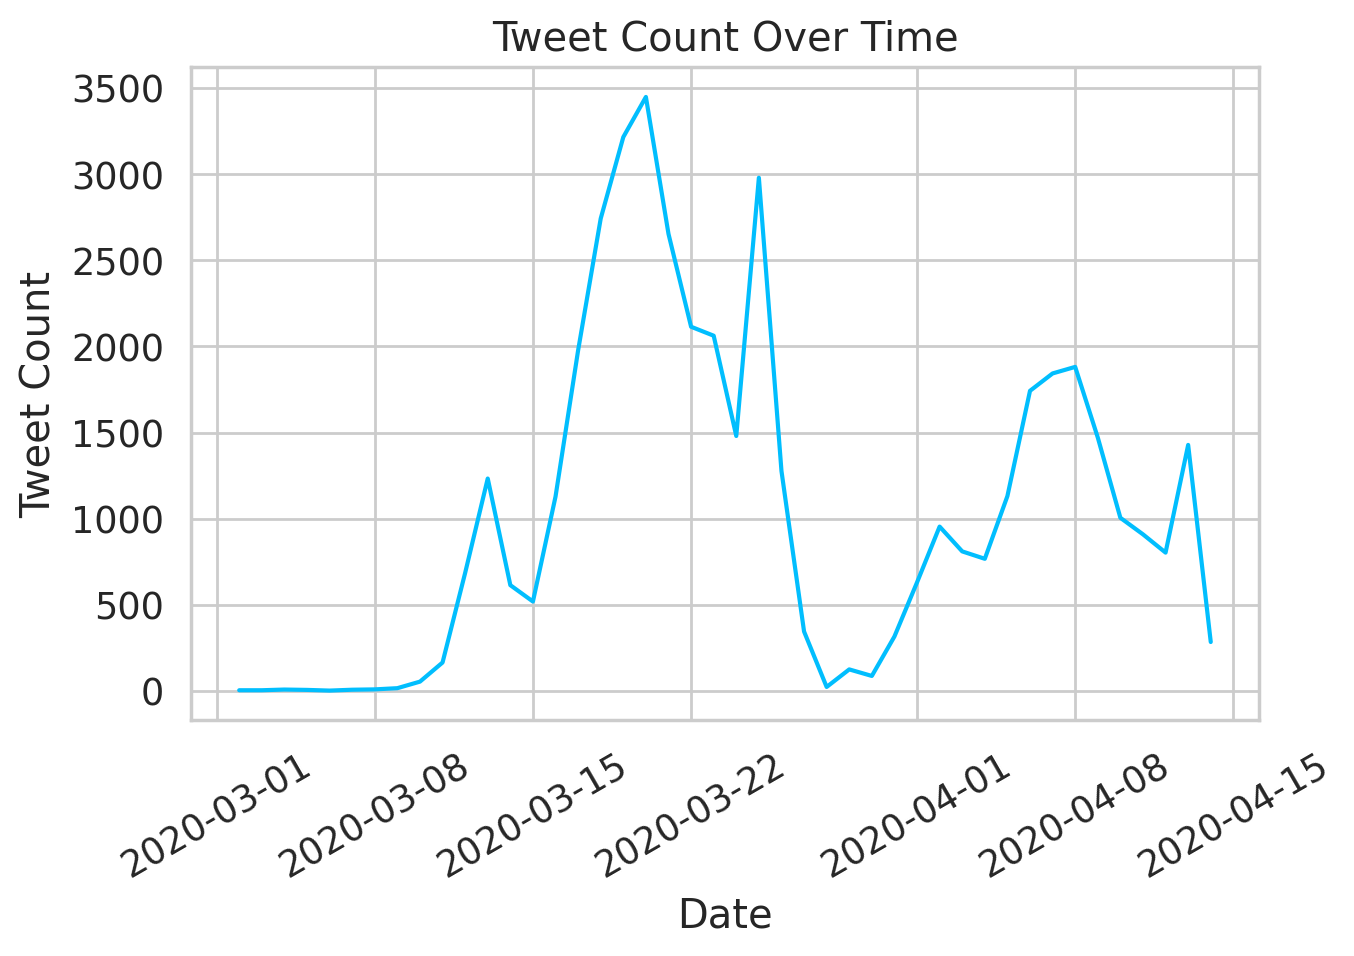

In [ ]:
# =============================
# Basic Date Processing
# =============================
df["TweetAt"] = pd.to_datetime(df["TweetAt"], format="%d-%m-%Y")

daily_counts = df.groupby(df["TweetAt"].dt.date).size()

plt.figure(figsize=(7, 5))
plt.plot(daily_counts.index, daily_counts.values)
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.title("Tweet Count Over Time")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
# =============================
# Remove Duplicates & Keep Relevant Columns
# =============================
df.drop_duplicates(subset="OriginalTweet", inplace=True)
df = df[["TweetAt", "OriginalTweet", "Sentiment"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44955 entries, 0 to 44954
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TweetAt        44955 non-null  datetime64[ns]
 1   OriginalTweet  44955 non-null  object        
 2   Sentiment      44955 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.0+ MB


In [ ]:
# =============================
# Text Cleaning Functions
# =============================
# Each function below performs one specific cleaning operation.
# They are combined later to form a full preprocessing pipeline.

def strip_emoji(text):
    """
    Remove all emoji characters from the text.
    Using the emoji package to safely filter emojis.
    """
    return emoji.replace_emoji(text, replace="")

def strip_all_entities(text):
    """
    Clean links, mentions, ASCII noise, punctuation,
    and convert the text to lowercase.
    """
    # Remove newline characters and lowercase text
    text = text.replace("\r", "").replace("\n", " ").lower()

    # Remove mentions (@username) and URLs
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)

    # Remove non-ASCII characters (e.g., stray corrupted bytes)
    text = re.sub(r"[^\x00-\x7f]", r"", text)

    # Remove punctuation and special characters
    banned_list = string.punctuation + "Ã" + "±" + "ã" + "¼" + "â" + "»" + "§"
    table = str.maketrans("", "", banned_list)
    text = text.translate(table)

    return text

def clean_hashtags(tweet):
    """
    Remove trailing hashtags entirely,
    but keep words that have '#' inside the sentence by removing the '#'.
    """
    # Remove hashtags at the end of the sentence
    new_tweet = " ".join(
        word.strip()
        for word in re.split(
            r"#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)", tweet
        )
    )
    # Remove the '#' symbol for inline hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split("#|_", new_tweet))
    return new_tweet2

def filter_chars(text):
    """
    Remove words containing '$' or '&' characters.
    These symbols often appear in corrupted text or ads.
    """
    cleaned = []
    for word in text.split(" "):
        if ("$" in word) or ("&" in word):
            cleaned.append("")  # remove word
        else:
            cleaned.append(word)
    return " ".join(cleaned)

def remove_mult_spaces(text):
    """
    Replace multiple spaces with a single space.
    Ensures clean and consistent spacing.
    """
    return re.sub(r"\s\s+", " ", text)

In [ ]:
# =============================
# Apply Text Cleaning
# =============================
# We combine the cleaning functions in the correct order.
# Each tweet is processed step-by-step through the pipeline.

clean_texts = []
for t in df["OriginalTweet"]:
    cleaned = strip_emoji(t)                 # 1. remove emojis
    cleaned = strip_all_entities(cleaned)    # 2. remove URLs, mentions, punctuation
    cleaned = clean_hashtags(cleaned)        # 3. clean hashtag patterns
    cleaned = filter_chars(cleaned)          # 4. remove unwanted symbols ($, &)
    cleaned = remove_mult_spaces(cleaned)    # 5. collapse multiple spaces
    clean_texts.append(cleaned)

df["text_clean"] = clean_texts

# Show an example after cleaning
df["text_clean"].head()

,text_clean
0,and and
1,advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate su...
2,coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak
3,my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 co...
4,me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes sh...


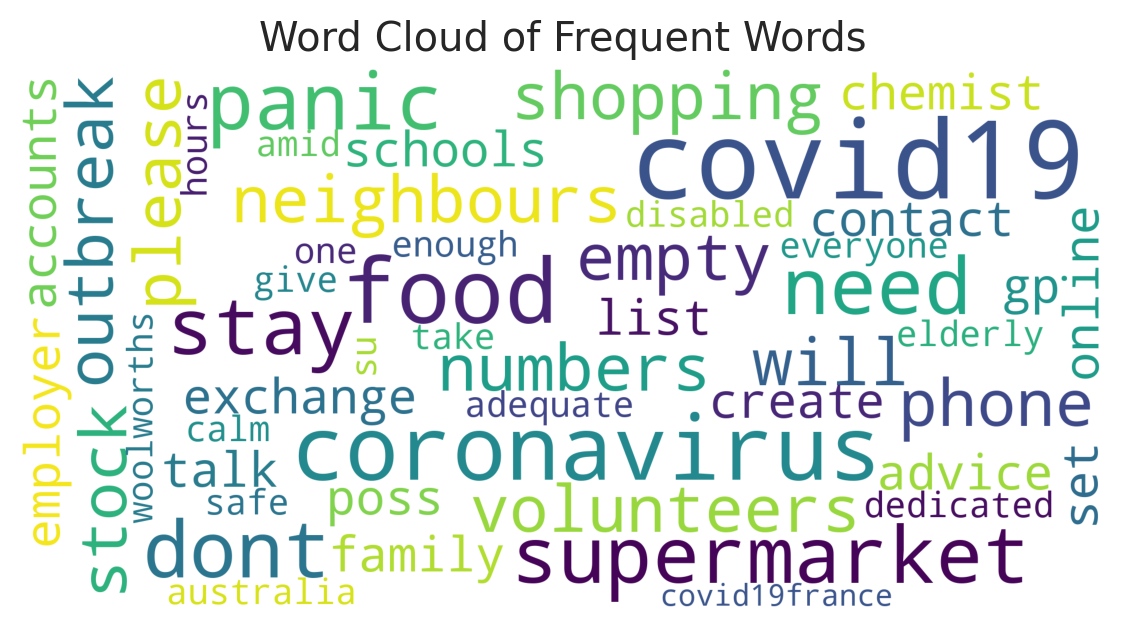

In [ ]:
# =============================
# Word Cloud Visualization
# =============================
# A word cloud helps visualize the most frequent words in the cleaned corpus.

word_cloud = WordCloud(
    background_color="white",
    stopwords=set(STOPWORDS),
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1
).generate(str(df["text_clean"]))

plt.figure(figsize=(7, 6))
plt.axis("off")
plt.imshow(word_cloud)
plt.title("Word Cloud of Frequent Words")
plt.show()

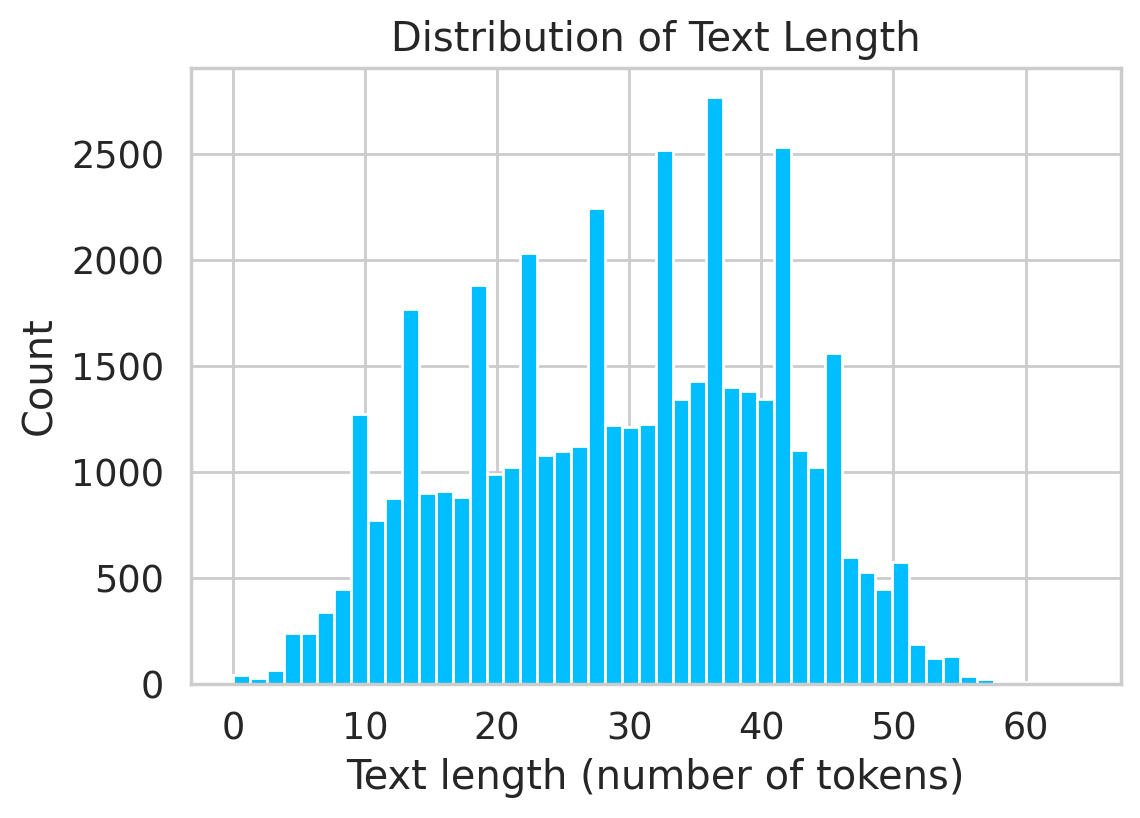

In [ ]:
# =============================
# Sentence Length Distribution
# =============================
# Compute the number of tokens per tweet to examine text length distribution.

text_len = df["text_clean"].apply(lambda x: len(x.split()))
df["text_len"] = text_len

plt.figure(figsize=(6, 4))
plt.hist(df["text_len"], bins=50)
plt.xlabel("Text length (number of tokens)")
plt.ylabel("Count")
plt.title("Distribution of Text Length")
plt.show()

In [ ]:
# =============================
# Remove Very Short Samples
# =============================
# Extremely short texts (e.g., length < 10 tokens) often contain no useful context.

df = df[df["text_len"] > 10].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42289 entries, 0 to 42288
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TweetAt        42289 non-null  datetime64[ns]
 1   OriginalTweet  42289 non-null  object        
 2   Sentiment      42289 non-null  object        
 3   text_clean     42289 non-null  object        
 4   text_len       42289 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.6+ MB


In [ ]:

# =============================
# Label Encoding
# =============================
# Convert sentiment labels from text to numeric IDs.
# This is necessary for model training since the classifier outputs numeric classes.

df["Sentiment"] = df["Sentiment"].replace({
    "Extremely Positive": "Positive",
    "Extremely Negative": "Negative"
})

le = LabelEncoder()
df["label_id"] = le.fit_transform(df["Sentiment"])

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

df["Sentiment"].value_counts()

Number of classes: 3


,count
Sentiment,
Positive,18955
Negative,16397
Neutral,6937


In [ ]:
# =============================
# Chronological Train / Val / Test Split
# =============================
# We sort the dataset by time to simulate a realistic temporal scenario.
# Earlier tweets are used for training, more recent ones for validation and testing.

df = df.sort_values("TweetAt").reset_index(drop=True)

# Compute index boundaries for the split:
# Train = 60%, Validation = 20%, Test = 20%
n = len(df)
train_end = int(n * 0.6)
val_end   = int(n * 0.8)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

print("Dataset sizes:")
print(len(train_df), len(val_df), len(test_df))

Dataset sizes:
25373 8458 8458


In [ ]:
# =============================
# Check Label Distribution in Each Split
# =============================
# Important for ensuring class balance and avoiding data leakage.

def show_distribution(df_split, name):
    """
    Print class counts and percentage distribution for inspection.
    """
    print(f"{name} label distribution:")
    counts = df_split["label_id"].value_counts()
    percentages = df_split["label_id"].value_counts(normalize=True) * 100

    display(pd.DataFrame({
        "count": counts,
        "percentage (%)": percentages.round(2)
    }))
    print("-" * 50)

show_distribution(train_df, "Train")
show_distribution(val_df, "Validation")
show_distribution(test_df, "Test")

Train label distribution:


,count,percentage (%)
label_id,,
2,11143,43.92
0,10298,40.59
1,3932,15.50


--------------------------------------------------
Validation label distribution:


,count,percentage (%)
label_id,,
2,3795,44.87
0,3131,37.02
1,1532,18.11


--------------------------------------------------
Test label distribution:


,count,percentage (%)
label_id,,
2,4017,47.49
0,2968,35.09
1,1473,17.42


--------------------------------------------------


In [ ]:
# =============================
# Keep Only Clean Text + Labels
# =============================
# Rename the cleaned text column to "text" for consistency with the LSTM pipeline.

train_df = train_df[["text_clean", "label_id"]].rename(columns={"text_clean": "text"})
val_df   = val_df[["text_clean", "label_id"]].rename(columns={"text_clean": "text"})
test_df  = test_df[["text_clean", "label_id"]].rename(columns={"text_clean": "text"})

print("Sample after renaming:")
display(train_df.head())

Sample after renaming:


,text,label_id
0,trending new yorkers encounter empty supermarket shelves pictured wegmans in brooklyn soldout online grocers foodkick maxdelivery as coronavirusfearing shoppers stock up,0
1,when i couldnt find hand sanitizer at fred meyer i turned to amazon but 11497 for a 2 pack of purellcheck out how coronavirus concerns are driving up prices,2
2,find out how you can protect yourself and loved ones from coronavirus,2
3,panic buying hits newyork city as anxious shoppers stock up on foodampmedical supplies after healthcare worker in her 30s becomes bigapple 1st confirmed coronavirus patient or a bloomberg staged e...,0
4,toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate covid19 9news corvid19 7newsmelb dunnypapergate costco one week everyone buying baby milk powder the next everyone buying ...,1


In [ ]:
# =============================
# BERT Tokenizer
# =============================
# We load the tokenizer corresponding to the pretrained multilingual BERT model.
# The tokenizer handles:
#   - Subword tokenization (WordPiece)
#   - Adding special tokens ([CLS], [SEP])
#   - Padding / truncation rules
#   - Mapping tokens to integer IDs

tokenizer = BertTokenizerFast.from_pretrained(
    "bert-base-multilingual-cased",
    do_lower_case=True  # lowercasing helps for multilingual noisy datasets
)

print("Tokenizer loaded.")

# =============================
# Analyze Token Length Distribution
# =============================
# Before deciding on max_length for BERT,
# we compute how long the tokenized tweets actually are.

token_lens = []

for txt in df["text_clean"].values:
    # Tokenize and get length (with truncation to avoid overflow)
    tokens = tokenizer.encode(txt, max_length=128, truncation=True)
    token_lens.append(len(tokens))

max_len = np.max(token_lens)
print(f"Maximum tokenized sentence length: {max_len}")

Tokenizer loaded.
Maximum tokenized sentence length: 100


In [ ]:
# =============================
# BERT Dataset & DataLoader
# =============================
# We create a PyTorch Dataset class to handle tokenization dynamically.
# This approach is cleaner, memory-efficient, and consistent with modern NLP pipelines.
# It also mirrors the LSTM project structure you are following.

class BertTextDataset(Dataset):
    """
    Dataset for BERT classification.
    Each sample returns:
      - input_ids: token indices
      - attention_mask: mask indicating which tokens should be attended to
      - labels: sentiment class ID
    """
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df["text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        # Remove the batch dimension
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Quick dataset check
sample_item = BertTextDataset(train_df, tokenizer, max_len=BERT_CFG["max_len"])[0]
for k, v in sample_item.items():
    print(k, v.shape)
print(sample_item)

input_ids torch.Size([128])
attention_mask torch.Size([128])
labels torch.Size([])
{'input_ids': tensor([  101, 54963, 10230, 10751, 13672, 97720, 10107, 84538, 65042, 25212,
        60336, 10833, 86506, 36761, 10162, 21437, 27382, 10106, 93742, 11140,
        34417, 15337, 17514, 13893, 30518, 45596, 10943, 18301, 10506, 11263,
        71118, 14494, 37884, 10157, 10146, 31206, 37715, 10251, 14601, 96025,
        39090, 24193, 20511, 10741,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   

In [ ]:
# =============================
# Build Custom BERT Classification Model
# =============================
# Instead of using BertForSequenceClassification,
# we build our own classifier on top of the pretrained BertModel.
#
# Advantages for teaching:
#   1. Students see how BERT produces hidden states / pooled_output.
#   2. We can freely design the classifier (multiple Dense layers, Dropout, etc.).
#   3. More transparent than the built-in HuggingFace classifier.
#
# Architecture:
#   [CLS] embedding (768-dim from BERT)
#         ↓
#     Dropout(p = 0.1)
#         ↓
#     Linear(768 → num_classes)
#         ↓
#     Logits


from transformers import BertModel


class BertClassifier(nn.Module):
    """
    Custom BERT classifier with:
      - Pretrained BERT base model
      - Dropout layer for regularization
      - Final Dense layer for classification

    Inputs:
      input_ids: token indices
      attention_mask: mask indicating which tokens are real tokens

    Output:
      logits: raw class scores (batch_size × num_classes)
    """

    def __init__(self, pretrained_model_name: str, num_classes: int, dropout: float = 0.1):
        super().__init__()

        # Load pretrained BERT encoder (no classification head)
        self.bert = BertModel.from_pretrained(pretrained_model_name)

        # Hidden size of BERT-base is 768
        hidden_size = self.bert.config.hidden_size

        # Dropout for regularization
        self.drop = nn.Dropout(p=dropout)

        # Final dense layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass:
        - BERT returns: (last_hidden_state, pooled_output, ...)
        - We use pooled_output (the [CLS] embedding) for classification.
        """

        # return_dict=False -> BERT outputs tuple instead of dict
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )  # pooled_output shape = (batch, 768)

        x = self.drop(pooled_output)
        logits = self.fc(x)
        return logits


# =============================
# Example: build model once
# =============================
example_model = BertClassifier(
    pretrained_model_name=BERT_CFG["pretrained_model"],
    num_classes=num_classes
).to(device)

print("Custom BERT classifier built successfully.")
example_model

Custom BERT classifier built successfully.


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
# =============================
# Train / Eval functions for Custom BERT Classifier
# =============================
# These functions follow the same structure as the LSTM version,
# but adapted for BERT:
#   - Inputs are dictionaries containing input_ids and attention_mask.
#   - We manually compute loss using CrossEntropyLoss.
#   - Scheduler (optional) performs linear warmup + decay.


def train_epoch_bert(model, loader, loss_fn, optimizer, scheduler=None):
    """
    Train the model for one epoch.

    Key steps:
      - Set model to train mode
      - Forward pass through BERT
      - Compute loss and accuracy
      - Backpropagation + gradient clipping
      - Step optimizer and scheduler
    """
    model.train()

    losses = []
    correct = 0
    total = 0

    for batch in loader:

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()

        # Forward pass through our custom BERT classifier
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Compute loss manually (different from BertForSequenceClassification)
        loss = loss_fn(logits, labels)

        # Backpropagation
        loss.backward()

        # Gradient clipping helps stabilize training
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        # Compute batch accuracy
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        losses.append(loss.item())

    return np.mean(losses), correct / total



@torch.no_grad()
def eval_epoch_bert(model, loader, loss_fn):
    """
    Evaluate the model (no gradient updates).
    """
    model.eval()

    losses = []
    correct = 0
    total = 0

    for batch in loader:

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        # Forward pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Compute loss
        loss = loss_fn(logits, labels)

        # Accuracy
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        losses.append(loss.item())

    return np.mean(losses), correct / total

In [ ]:
# =============================
# BERT Hyperparameter Search
# =============================

bert_results_columns = [
    "batch_size", "lr", "best_val_loss", "val_acc", "test_acc", "seed"
]
bert_results_df = pd.DataFrame(columns=bert_results_columns)

grid  = BERT_CFG["grid"]
seeds = BERT_CFG["random_seeds"]

os.makedirs("./models_BERT", exist_ok=True)

for seed in seeds:
    setup_seed(seed)

    for batch_size, lr in itertools.product(grid["batch_size"], grid["lr"]):

        print("\n====================================================================")
        print(f"BERT | Seed {seed} | Batch Size = {batch_size} | LR = {lr}")
        print("====================================================================")

        # -----------------------------
        # Build Datasets & Dataloaders
        # -----------------------------
        train_dataset = BertTextDataset(train_df, tokenizer, max_len=BERT_CFG["max_len"])
        val_dataset   = BertTextDataset(val_df, tokenizer, max_len=BERT_CFG["max_len"])
        test_dataset  = BertTextDataset(test_df, tokenizer, max_len=BERT_CFG["max_len"])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
        test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

        # -----------------------------
        # Build Custom BERT Model
        # -----------------------------
        model = BertClassifier(
            pretrained_model_name=BERT_CFG["pretrained_model"],
            num_classes=num_classes
        ).to(device)

        # -----------------------------
        # Optimizer & Scheduler
        # -----------------------------
        optimizer = optim.AdamW(model.parameters(), lr=lr)
        loss_fn   = nn.CrossEntropyLoss()

        # Total training steps = number of batches × epochs
        total_steps = len(train_loader) * BERT_CFG["epochs"]

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        # -----------------------------
        # Early Stopping
        # -----------------------------
        best_val_loss = float("inf")
        best_state = None
        no_improve = 0

        # -----------------------------
        # Training Loop
        # -----------------------------
        for epoch in range(BERT_CFG["epochs"]):

            train_loss, train_acc = train_epoch_bert(
                model, train_loader, loss_fn, optimizer, scheduler
            )
            val_loss, val_acc = eval_epoch_bert(
                model, val_loader, loss_fn
            )

            print(f"\nEpoch {epoch+1}/{BERT_CFG['epochs']} | "
                  f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

            # Check improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_state = copy.deepcopy(model.state_dict())
                best_epoch = epoch + 1
                no_improve = 0
            else:
                no_improve += 1

                if no_improve >= BERT_CFG["patience"]:
                    print(f"Early stopping triggered! Best epoch = {best_epoch}")
                    break

        # -----------------------------
        # Restore Best Model
        # -----------------------------
        print(f"\nRestoring best model from epoch {best_epoch} ...")
        model.load_state_dict(best_state)

        # -----------------------------
        # Save Checkpoint
        # -----------------------------
        save_path = f"./models_BERT/best_bert_batch{batch_size}_lr{lr}_seed{seed}.pth"
        torch.save({
            "model_state_dict": best_state,
            "config": BERT_CFG,
            "label_encoder": le.classes_,
            "pretrained_model": BERT_CFG["pretrained_model"],
        }, save_path)

        print(f"Saved best model to: {save_path}")

        # -----------------------------
        # Final Test Evaluation
        # -----------------------------
        test_loss, test_acc = eval_epoch_bert(
            model, test_loader, loss_fn
        )

        print(f"Test Accuracy: {test_acc:.4f}")

        bert_results_df.loc[len(bert_results_df)] = [
            batch_size, lr, best_val_loss, val_acc, test_acc, seed
        ]

print("\n===== BERT Grid Search Results =====")
display(bert_results_df)


BERT | Seed 42 | Batch Size = 64 | LR = 2e-05

Epoch 1/10 | Train Loss: 0.7847 | Train Acc: 0.6409 | Val Loss: 0.5593 | Val Acc: 0.7932

Epoch 2/10 | Train Loss: 0.4573 | Train Acc: 0.8336 | Val Loss: 0.4217 | Val Acc: 0.8439

Epoch 3/10 | Train Loss: 0.3242 | Train Acc: 0.8896 | Val Loss: 0.3752 | Val Acc: 0.8717

Epoch 4/10 | Train Loss: 0.2442 | Train Acc: 0.9202 | Val Loss: 0.4087 | Val Acc: 0.8754

Epoch 5/10 | Train Loss: 0.1874 | Train Acc: 0.9404 | Val Loss: 0.4049 | Val Acc: 0.8746

Epoch 6/10 | Train Loss: 0.1500 | Train Acc: 0.9527 | Val Loss: 0.4393 | Val Acc: 0.8774
Early stopping triggered! Best epoch = 3

Restoring best model from epoch 3 ...
Saved best model to: ./models_BERT/best_bert_batch64_lr2e-05_seed42.pth
Test Accuracy: 0.8788

BERT | Seed 42 | Batch Size = 64 | LR = 1e-05

Epoch 1/10 | Train Loss: 0.8550 | Train Acc: 0.5920 | Val Loss: 0.6451 | Val Acc: 0.7437

Epoch 2/10 | Train Loss: 0.5296 | Train Acc: 0.7988 | Val Loss: 0.4787 | Val Acc: 0.8188

Epoch 3/10 

,batch_size,lr,best_val_loss,val_acc,test_acc,seed
0,64.0,0.00002,0.375169,0.877394,0.878813,42.0
1,64.0,0.00001,0.403276,0.874320,0.869236,42.0
2,64.0,0.00010,0.374823,0.871719,0.884488,42.0
3,128.0,0.00002,0.374160,0.875857,0.879404,42.0
4,128.0,0.00001,0.424178,0.858714,0.861551,42.0
5,128.0,0.00010,0.398107,0.874911,0.874084,42.0


In [ ]:
# =============================
# Select Best Row from Grid Search
# =============================
# We select the configuration with the minimum validation loss.
# This is the most reliable criterion for model generalization.
best_bert_row = bert_results_df.sort_values("best_val_loss").iloc[0]
print("\nBest configuration found:")
display(best_bert_row)


Best configuration found:


,3
batch_size,128.000000
lr,0.000020
best_val_loss,0.374160
val_acc,0.875857
test_acc,0.879404
seed,42.000000


In [ ]:
# Please run these codes when you do the training by yourself.
'''
best_batch   = int(best_bert_row["batch_size"])
best_lr      = best_bert_row["lr"]
best_seed    = int(best_bert_row["seed"])

# Reconstruct checkpoint path
checkpoint_path = f"./models_BERT/best_bert_batch{best_batch}_lr{best_lr}_seed{best_seed}.pth"
print(f"\nLoading best model from: {checkpoint_path}")

# =============================
# Load Checkpoint
# =============================
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
print("Checkpoint loaded successfully.")
'''

In [ ]:
# Load the saved model from the sharing link
!pip install -U gdown

import torch
import gdown

url = 'https://drive.google.com/file/d/1vgiaYznuYNnV7CCkbQjOIdIUQCulKJCP/view?usp=sharing'
output = './models_LSTM/LSTM_model.pth'
gdown.download(url, output, quiet=False, fuzzy=True)

# 加载模型
checkpoint = torch.load(output, map_location=device, weights_only=False)

best_batch = 128
best_lr = 2e-5
best_seed = 42

Downloading...
From (original): https://drive.google.com/uc?id=1vgiaYznuYNnV7CCkbQjOIdIUQCulKJCP
From (redirected): https://drive.google.com/uc?id=1vgiaYznuYNnV7CCkbQjOIdIUQCulKJCP&confirm=t&uuid=713c2459-ee62-404c-b40b-3df06129ca91
To: /content/drive/MyDrive/TextClassification/Codes/models_LSTM/LSTM_model.pth
100%|██████████| 712M/712M [00:05<00:00, 139MB/s] 


In [ ]:
label_classes = checkpoint["label_encoder"]
num_classes   = len(label_classes)
bert_config   = checkpoint["config"]
pretrained_model_name = checkpoint["pretrained_model"]

In [ ]:
# =============================
# Rebuild Model Architecture
# =============================
# IMPORTANT:
# The model architecture *must* match the saved checkpoint,
# otherwise the weight loading will fail.

final_model = BertClassifier(
    pretrained_model_name=pretrained_model_name,
    num_classes=num_classes
).to(device)

final_model.load_state_dict(checkpoint["model_state_dict"])
final_model.eval()

print("Final BERT model restored and ready for evaluation.")

Final BERT model restored and ready for evaluation.


In [ ]:
# =============================
# Rebuild Dataloaders (using best batch size)
# =============================
# To ensure consistent evaluation, we must rebuild DataLoaders.
# The tokenizer and preprocessing must match the training phase.

train_loader = DataLoader(
    BertTextDataset(train_df, tokenizer, max_len=bert_config["max_len"]),
    batch_size=best_batch,
    shuffle=True
)

val_loader = DataLoader(
    BertTextDataset(val_df, tokenizer, max_len=bert_config["max_len"]),
    batch_size=best_batch,
    shuffle=False
)

test_loader = DataLoader(
    BertTextDataset(test_df, tokenizer, max_len=bert_config["max_len"]),
    batch_size=best_batch,
    shuffle=False
)

loss_fn = nn.CrossEntropyLoss()

In [ ]:
# =============================
# Final Test Evaluation
# =============================
test_loss, test_acc = eval_epoch_bert(final_model, test_loader, loss_fn)

print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.8794


In [ ]:
# =============================
# Collect Predictions
# =============================
# Function to collect predictions and ground truth labels.
# No gradients are needed during inference, so @torch.no_grad() is used.

@torch.no_grad()
def get_preds_bert(model, loader):
    model.eval()

    all_preds = []
    all_labels = []

    for batch in loader:

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].cpu().numpy()

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = logits.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    return np.array(all_preds), np.array(all_labels)


# Collect predictions for the test set
y_pred, y_true = get_preds_bert(final_model, test_loader)
print("Prediction collection completed.")

Prediction collection completed.



========== Classification Report ==========
              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      2968
     Neutral       0.86      0.77      0.81      1473
    Positive       0.90      0.91      0.90      4017

    accuracy                           0.88      8458
   macro avg       0.87      0.86      0.86      8458
weighted avg       0.88      0.88      0.88      8458



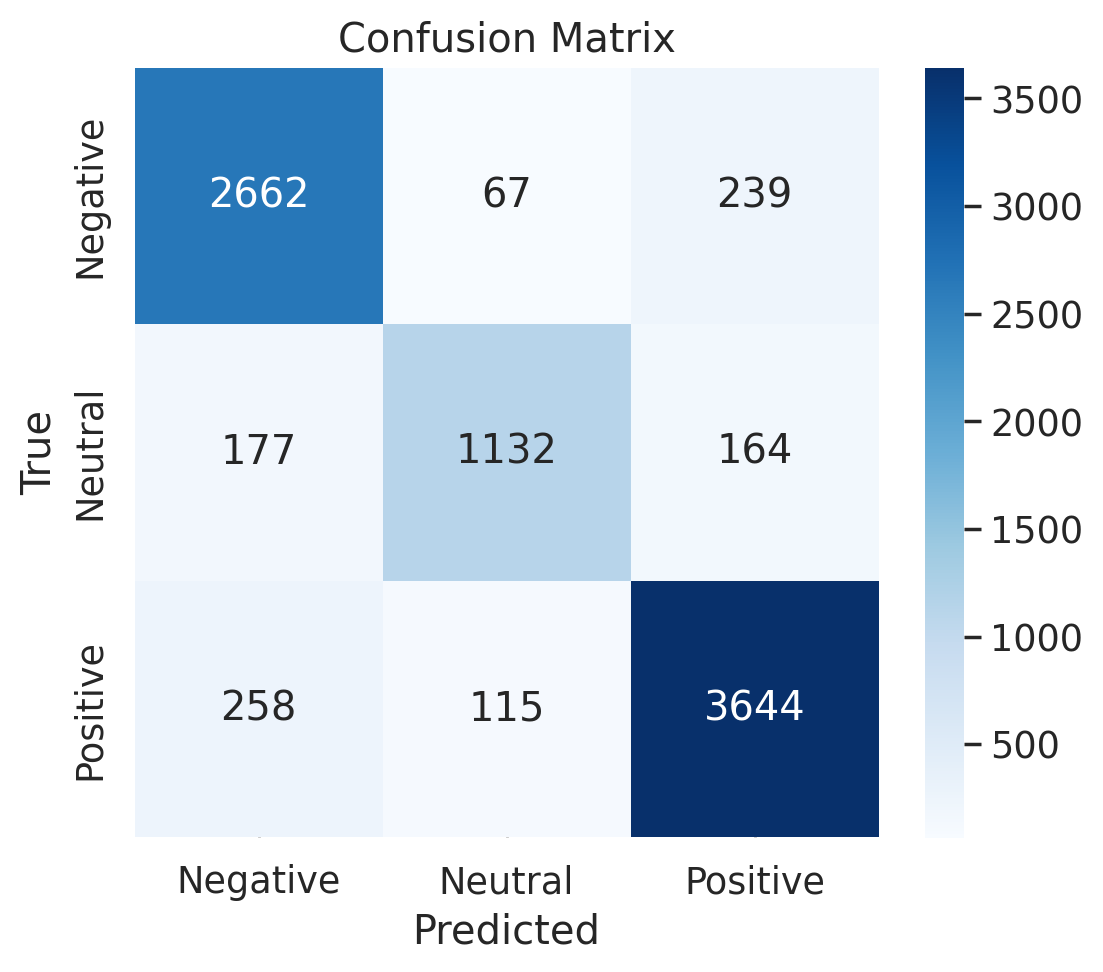

In [ ]:
# -------------------------------------------------------
# Print classification report
# -------------------------------------------------------
print("\n========== Classification Report ==========")
print(classification_report(y_true, y_pred, target_names=label_classes))

# -------------------------------------------------------
# Confusion matrix
# -------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

![Metrics.png](https://codefinity-content-media.s3.eu-west-1.amazonaws.com/b71ff7ac-3932-41d2-a4d8-060e24b00129/MetricsSummary.png)